In [1]:
# Task:
# for each hour, predict PM2.5 at each station,
# based on other observations such as temperature
# and wind speed in the same hour

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# loading data
# the data is sorted by utc_time
df = pd.read_csv('beijing_air_quality_data.csv',
                 parse_dates=['utc_time'])

In [4]:
target = ["pm25"]
features = ["temperature", "pressure", "humidity", "wind_speed_kmph"]

In [5]:
df[target].isnull().sum()

pm25    3372
dtype: int64

In [6]:
df['target_is_NA'] = df[target].isnull()

In [7]:
# explore the dataset by:
# descriptive statistics
# visualizations

# Hint: refer to section 4.3 and 4.4

In [8]:
df.head()

,site_id,utc_time,epoch_time,lat,lon,sitetype,pm25,pm10,no2,co,o3,so2,weather,temperature,pressure,humidity,wind_direction,wind_speed_kmph,target_is_NA
0,dongsi_aq,2018-04-28,1524873600,39.93,116.42,Urban Stations,59.0,172.0,96.0,0.8,8.0,5.0,CLEAR_DAY,17.03,1006.54,40.47,101.19,2.77,False
1,tiantan_aq,2018-04-28,1524873600,39.89,116.41,Urban Stations,52.0,187.0,104.0,0.8,3.0,5.0,CLEAR_DAY,17.09,1006.78,40.85,104.62,2.34,False
2,guanyuan_aq,2018-04-28,1524873600,39.93,116.34,Urban Stations,54.0,165.0,91.0,0.6,13.0,7.0,CLEAR_DAY,17.24,1004.53,40.50,89.65,2.86,False
3,wanshouxigong_aq,2018-04-28,1524873600,39.88,116.35,Urban Stations,51.0,184.0,93.0,0.9,6.0,5.0,CLEAR_DAY,17.30,1005.60,40.86,102.21,2.46,False
4,aotizhongxin_aq,2018-04-28,1524873600,39.98,116.40,Urban Stations,58.0,134.0,86.0,0.7,6.0,3.0,CLEAR_DAY,16.98,1005.89,39.64,82.69,3.62,False


In [9]:
df[target].describe()

,pm25
count,26868.000000
mean,58.937398
std,43.684511
min,3.000000
25%,28.000000
50%,48.000000
75%,78.000000
max,705.000000


In [10]:
df[features].describe()

,temperature,pressure,humidity,wind_speed_kmph
count,30240.000000,30240.000000,30240.000000,30240.000000
mean,21.957700,993.312064,35.776479,9.403533
std,5.416088,17.858515,19.158965,5.292269
min,5.000000,921.400000,5.450000,0.500000
25%,17.640000,987.470000,20.887500,5.470000
50%,21.790000,997.500000,31.900000,8.335000
75%,26.000000,1005.152500,46.580000,12.280000
max,36.000000,1019.490000,96.930000,39.120000


In [11]:
# %matplotlib notebook
%matplotlib inline

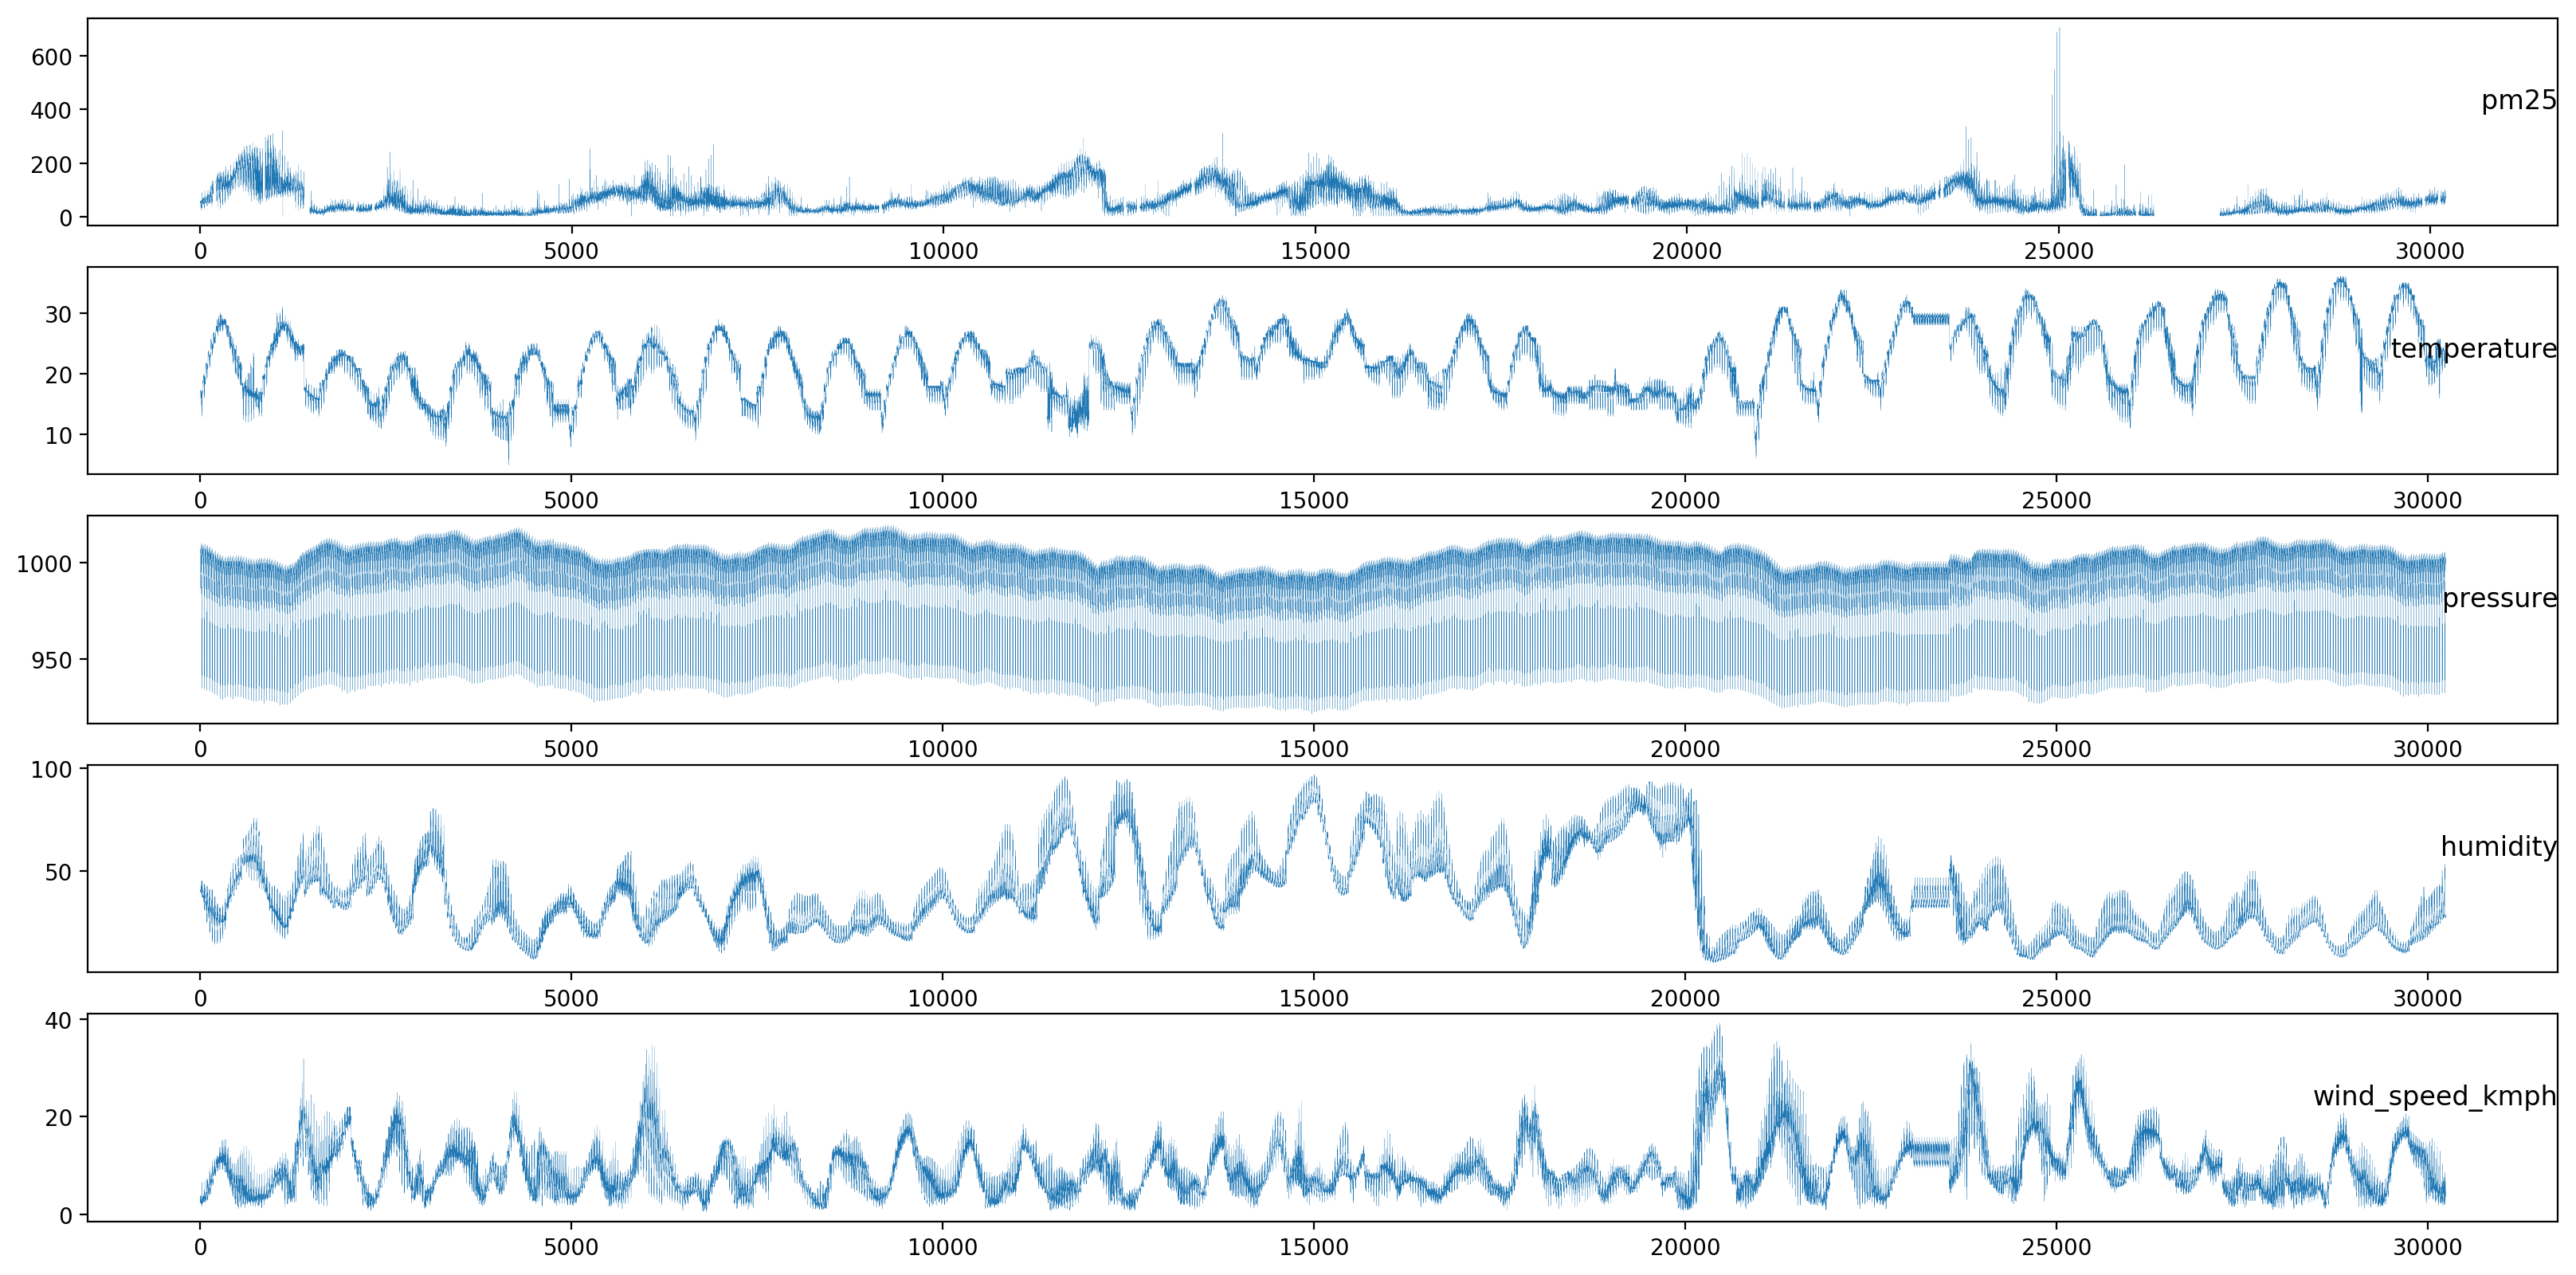

In [12]:
plt.figure(figsize=(20, 10), dpi=200)
is_normalized = False
for idx, col in enumerate(target + features):
    plt.subplot(len(target + features), 1, idx+1)
    if is_normalized:
        plt.plot((df[col] - df[col].mean()) / df[col].std(), linewidth=0.1)
    else:
        plt.plot(df[col], linewidth=0.1)
    plt.title(col, y=0.5, loc='right')

In [13]:
# fill missing air quality data

# Hint: refer to section 4.3
#       you can use simple methods, such as mean value
#       you may also consider spatial/temporal interpolation
#       e.g., using values in the nearby stations/hours

In [14]:
# using mean for interpolation
# df[target] = df[target].fillna(df[target].mean())

In [15]:
# more complex interpolation

# it will take some time...

# the PM2.5 density plot shown later is more smoother using this interpolation method

# ignore some warning messages
pd.options.mode.chained_assignment = None

station_ids = pd.unique(df['site_id'])

df['hour'] = df['utc_time'].dt.hour

# for each station, using temporal interpolation (maximum number of consecutive missing values is 2)
for station_id in station_ids:
    df.loc[df['site_id'] == station_id, target] = df.loc[
        df['site_id'] == station_id, target].interpolate(method="linear", axis=0,
                                                              limit_direction="both",
                                                              limit_area="inside",
                                                              limit=2)

# for each hour, using spatial interpolation (inverse distance weighting)
def interpolated_f(non_na_station_lats, non_na_station_lons, non_nan_values, na_station_lats, na_station_lons):
    p = 2
    ret = []
    for _x, _y in zip(na_station_lons, na_station_lats):
        weighted_values_sum = 0.0
        sum_of_weights = 0.0
        for x, y, value in zip(non_na_station_lons, non_na_station_lats, non_nan_values):
            weight = (((_x - x) ** 2 + (_y - y) ** 2) ** 0.5) ** p
            sum_of_weights += weight
            weighted_values_sum += weight * value
        ret.append(weighted_values_sum / sum_of_weights)
    return ret

for idx, time in enumerate(pd.unique(df['epoch_time'])):
    
    one_hour_df = df.loc[df['epoch_time'] == time]
    air_quality_station_locations = one_hour_df[["lat", "lon"]]

    # interpolation based on current available air quality observations
    na_idx = one_hour_df[target].isnull().values
    na_idx = np.squeeze(np.asarray(na_idx))
    if na_idx.any():
        non_na_stations = air_quality_station_locations[~na_idx]
        non_na_values = one_hour_df[target][~na_idx].values
        na_stations = air_quality_station_locations[na_idx]
        if non_na_stations.shape[0] > (len(air_quality_station_locations) // 5):
            # if number of stations with non nan pm2.5 values is large enough, then do spatial interpolation
            interpolated_values = interpolated_f(non_na_stations['lat'].values,
                                                 non_na_stations['lon'].values,
                                                 non_na_values,
                                                 na_stations['lat'].values,
                                                 na_stations['lon'].values)
            one_hour_df.loc[na_idx, target] = interpolated_values
        else:
            # for fewer station, using average value for interpolation
            if len(non_na_values) > 0:
                one_hour_df['pm25'].fillna(np.mean(non_na_values), inplace=True)

        df.loc[df['epoch_time'] == time, :] = one_hour_df.values

# using mean value for each station at each hour

for station_id in station_ids:
    for hour in range(0, 24):
        mean_v = df.loc[(df['site_id'] == station_id) & (df['hour'] == hour), target].mean()
        df.loc[(df['site_id'] == station_id) & (df['hour'] == hour), target] = df.loc[
            (df['site_id'] == station_id) & (df['hour'] == hour), target].fillna(mean_v)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
#create a separate dataframe as checkpoint for saving time in testing
interpolated_df = df.copy()

In [17]:
df[target].describe()

,pm25
count,30240.000000
mean,58.712004
std,43.085238
min,3.000000
25%,28.000000
50%,48.500000
75%,77.000000
max,705.000000


In [18]:
df[target].isnull().sum()

pm25    0
dtype: int64

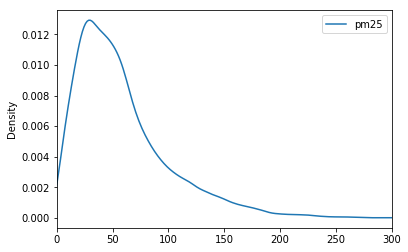

In [19]:
df[target].plot(kind='density', xlim=(0, 300))

In [20]:
# data normalization

# Hint: refer to section 4.2 and 4.3

In [21]:
for col in features:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [22]:
df[features].describe()

,temperature,pressure,humidity,wind_speed_kmph
count,3.024000e+04,3.024000e+04,3.024000e+04,3.024000e+04
mean,4.812141e-16,1.946474e-15,1.804553e-16,2.330881e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.130987e+00,-4.026766e+00,-1.582887e+00,-1.682366e+00
25%,-7.971989e-01,-3.271305e-01,-7.771285e-01,-7.432602e-01
50%,-3.096326e-02,2.345064e-01,-2.023323e-01,-2.019045e-01
75%,7.463505e-01,6.630134e-01,5.638886e-01,5.435224e-01
max,2.592701e+00,1.465852e+00,3.191901e+00,5.615071e+00


In [23]:
# prepare training data and test data

# Hint: refer to section 4.5

In [24]:
X = df[features].values

# y: [PM2.5, whether PM2.5 is missing before any interpolation]
y = df[target + ['target_is_NA']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# a boolean array showing whether PM2.5 is missing before interpolation
y_train_na_idx = y_train[:, 1].astype(bool)
# interpolated PM2.5 values
y_train = y_train[:, 0]

# a boolean array showing whether PM2.5 is missing before interpolation
y_test_na_idx = y_test[:, 1].astype(bool)
# interpolated PM2.5 values
y_test = y_test[:, 0]

In [25]:
# with training data, build a model to predict PM2.5
# based on other features such as temperature and wind speed

# Hint: refer to section 4.5
#       this is a regression task (not classification!)
#       you may just use a simple Linear Regression Model
#       pm2.5 = temperature + wind_speed + ...
#       sklearn.linear_model.LinearRegression

In [26]:
# we create an instance of Linear Regression Classifier
lin_reg = linear_model.LinearRegression()

In [27]:
# fit data
lin_reg = lin_reg.fit(X_train, y_train)

In [28]:
# make predictions on training data and test data

# Hint: refer to section 4.5

In [29]:
# predictions on training data
y_train_predicted = lin_reg.predict(X_train)

In [30]:
# predictions on test data
y_test_predicted = lin_reg.predict(X_test)

In [31]:
# evaluate your model on training data and test data

# Mean squared error is commonly used for regression:
# sklearn.metrics.mean_squared_error

# Hint: refer to section 4.5

In [32]:
# evaluate on training data
mean_squared_error(y_train, y_train_predicted)

1714.7786255422916

In [33]:
# evaluate on test data
mean_squared_error(y_test, y_test_predicted)

1754.5581170186708

In [34]:
# now we only evalate the original PM2.5 values (before filling missing value) on test data
mean_squared_error(y_test[~y_test_na_idx], y_test_predicted[~y_test_na_idx])

1825.507105435045

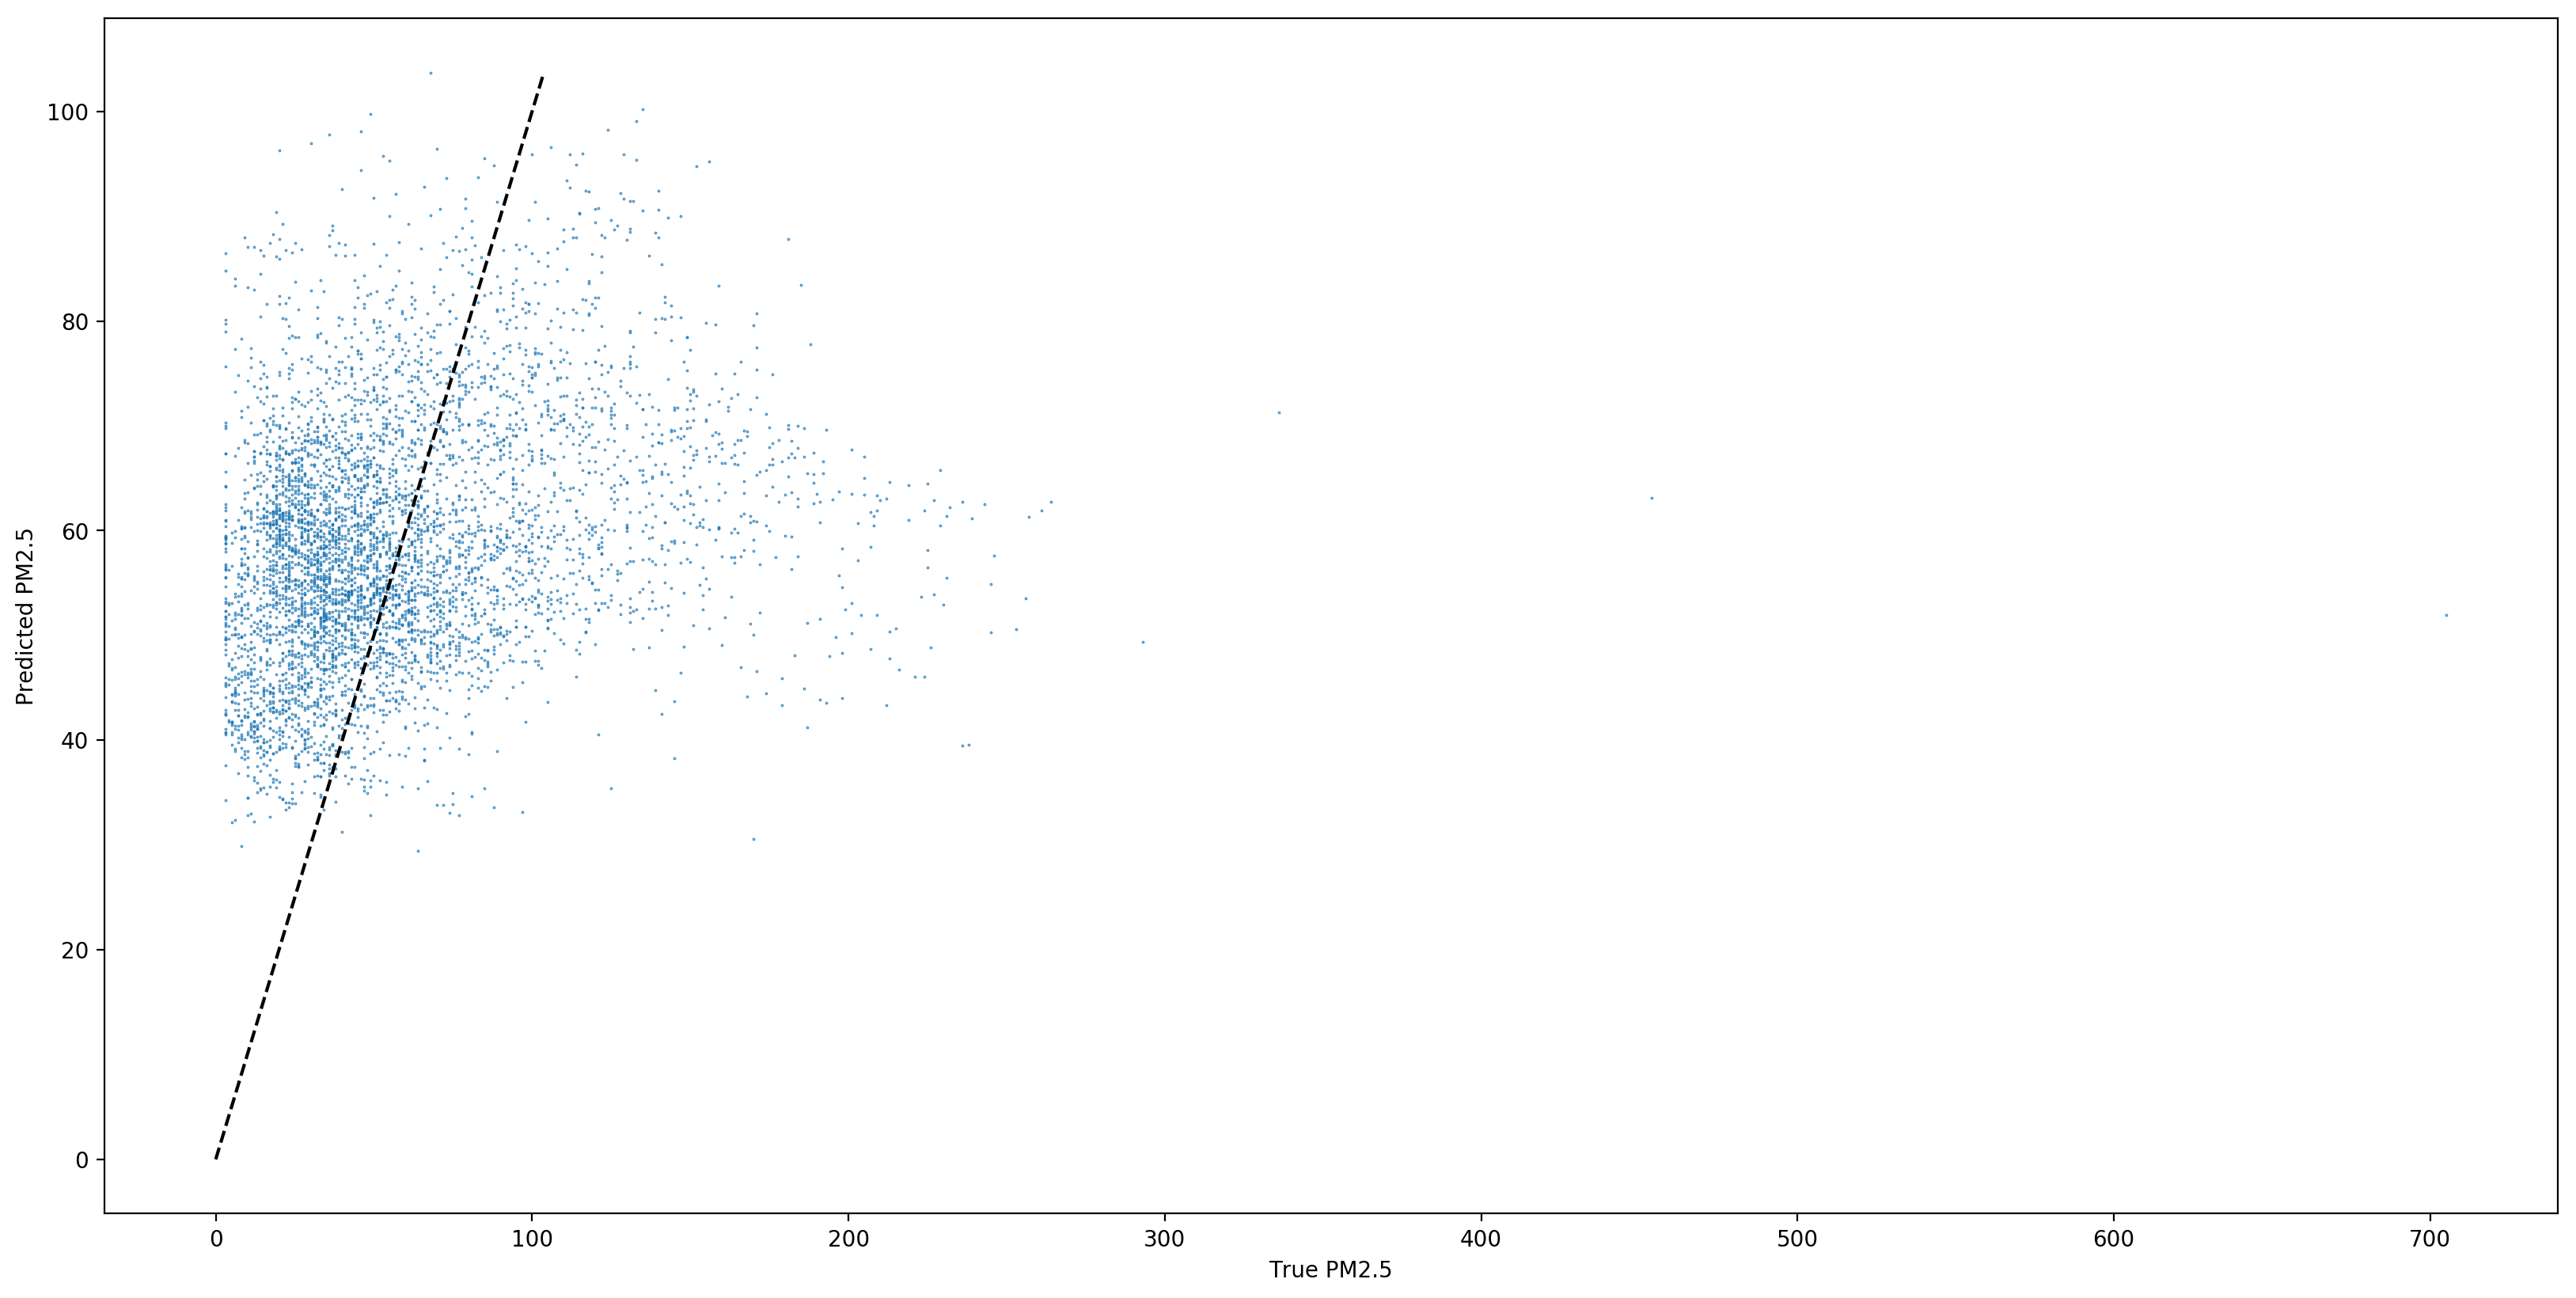

In [35]:
fig = plt.figure(figsize=(20,10), dpi=200)

plt.scatter(y_test[~y_test_na_idx], y_test_predicted[~y_test_na_idx], s=0.1) # "s" defines the size of the dots

# plot a line that shows the expected correlation between 
# the true pm2.5 value and the predicted pm2.5 value
max_val = min(y_test[~y_test_na_idx].max(), y_test_predicted[~y_test_na_idx].max())
plt.plot([0, max_val], [0, max_val], '--k') # '--': dashed,  'k': black
# for more line styles: see the official documentation: 
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html

plt.xlabel('True PM2.5')
plt.ylabel('Predicted PM2.5')
plt.show()


In [36]:
# Advanced topics for time series analysis
# If you still have time...

# How about not only using features in current hour,
# but also historical data?
# e.g., pm2.5 values in the previous 5 hours

# Hint: you may add more columns in the dataset

In [37]:
# for PM2.5 and all features, add their values in the previous 1 hour as new features
df = interpolated_df.copy()

df = df.sort_values(['site_id', 'utc_time'])

# try to tune the number of previous steps to take
prev_step = 3

for t in range(1, prev_step + 1):
    df[f'{target[0]}_t-{t}'] = df[target].shift(t)
    
for t in range (1,prev_step + 1):
    df.loc[df.site_id != df.site_id.shift(t), f'{target[0]}_t-{t}'] = np.nan

df = df.dropna()

In [38]:
df.head()

,site_id,utc_time,epoch_time,lat,lon,sitetype,pm25,pm10,no2,co,...,temperature,pressure,humidity,wind_direction,wind_speed_kmph,target_is_NA,hour,pm25_t-1,pm25_t-2,pm25_t-3
109,aotizhongxin_aq,2018-04-28 03:00:00,1524884400,39.98,116.4,Urban Stations,71.0,134.0,53.0,0.6,...,23.22,1003.53,31.32,141.91,5.28,False,3,69.0,64.0,58.0
144,aotizhongxin_aq,2018-04-28 04:00:00,1524888000,39.98,116.4,Urban Stations,78.0,134.0,54.0,0.6,...,24.47,1002.23,30.27,146.09,7.05,False,4,71.0,69.0,64.0
214,aotizhongxin_aq,2018-04-28 06:00:00,1524895200,39.98,116.4,Urban Stations,120.0,172.0,66.0,0.7,...,27.14,1000.28,26.52,160.33,9.72,False,6,99.0,78.0,71.0
249,aotizhongxin_aq,2018-04-28 07:00:00,1524898800,39.98,116.4,Urban Stations,136.0,190.0,77.0,0.7,...,27.69,999.49,25.85,170.05,10.40,False,7,120.0,99.0,78.0
284,aotizhongxin_aq,2018-04-28 08:00:00,1524902400,39.98,116.4,Urban Stations,141.0,192.0,48.0,0.7,...,28.48,998.64,25.72,178.24,10.53,False,8,136.0,120.0,99.0


In [39]:
# new training dataset and test dataset
# use also pm25_t-1, temperature_t-1, pressure_t-1, humidity_t-1, wind_speed_kmph_t-1 as training data
prev_targets = [f'{target[0]}_t-{t}' for t in range(1, prev_step + 1)]
X = df[features + prev_targets].values

# y: [PM2.5, whether PM2.5 is missing before any interpolation]
y = df[target + ['target_is_NA']].values

# use the same random state in previous split
# to better compare the results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12344)

# a boolean array showing whether PM2.5 is missing before interpolation
y_train_na_idx = y_train[:, 1].astype(bool)
# interpolated PM2.5 values
y_train = y_train[:, 0]

# a boolean array showing whether PM2.5 is missing before interpolation
y_test_na_idx = y_test[:, 1].astype(bool)
# interpolated PM2.5 values
y_test = y_test[:, 0]

In [40]:
# new linear regression model
new_lin_reg = linear_model.LinearRegression()

# fit new data
new_lin_reg = new_lin_reg.fit(X_train, y_train)

In [41]:
# predictions on training data
y_train_predicted = new_lin_reg.predict(X_train)

In [42]:
# predictions on test data
y_test_predicted = new_lin_reg.predict(X_test)

In [43]:
# we will see that MSE is significantly reduced

In [44]:
# evaluate on training data
mean_squared_error(y_train, y_train_predicted)

174.88840149513518

In [45]:
# evaluate on test data
mean_squared_error(y_test, y_test_predicted)

185.61909125085066

In [46]:
# now we only evalate the original PM2.5 values (before filling missing value) on test data
mean_squared_error(y_test[~y_test_na_idx], y_test_predicted[~y_test_na_idx])

186.71999310571977

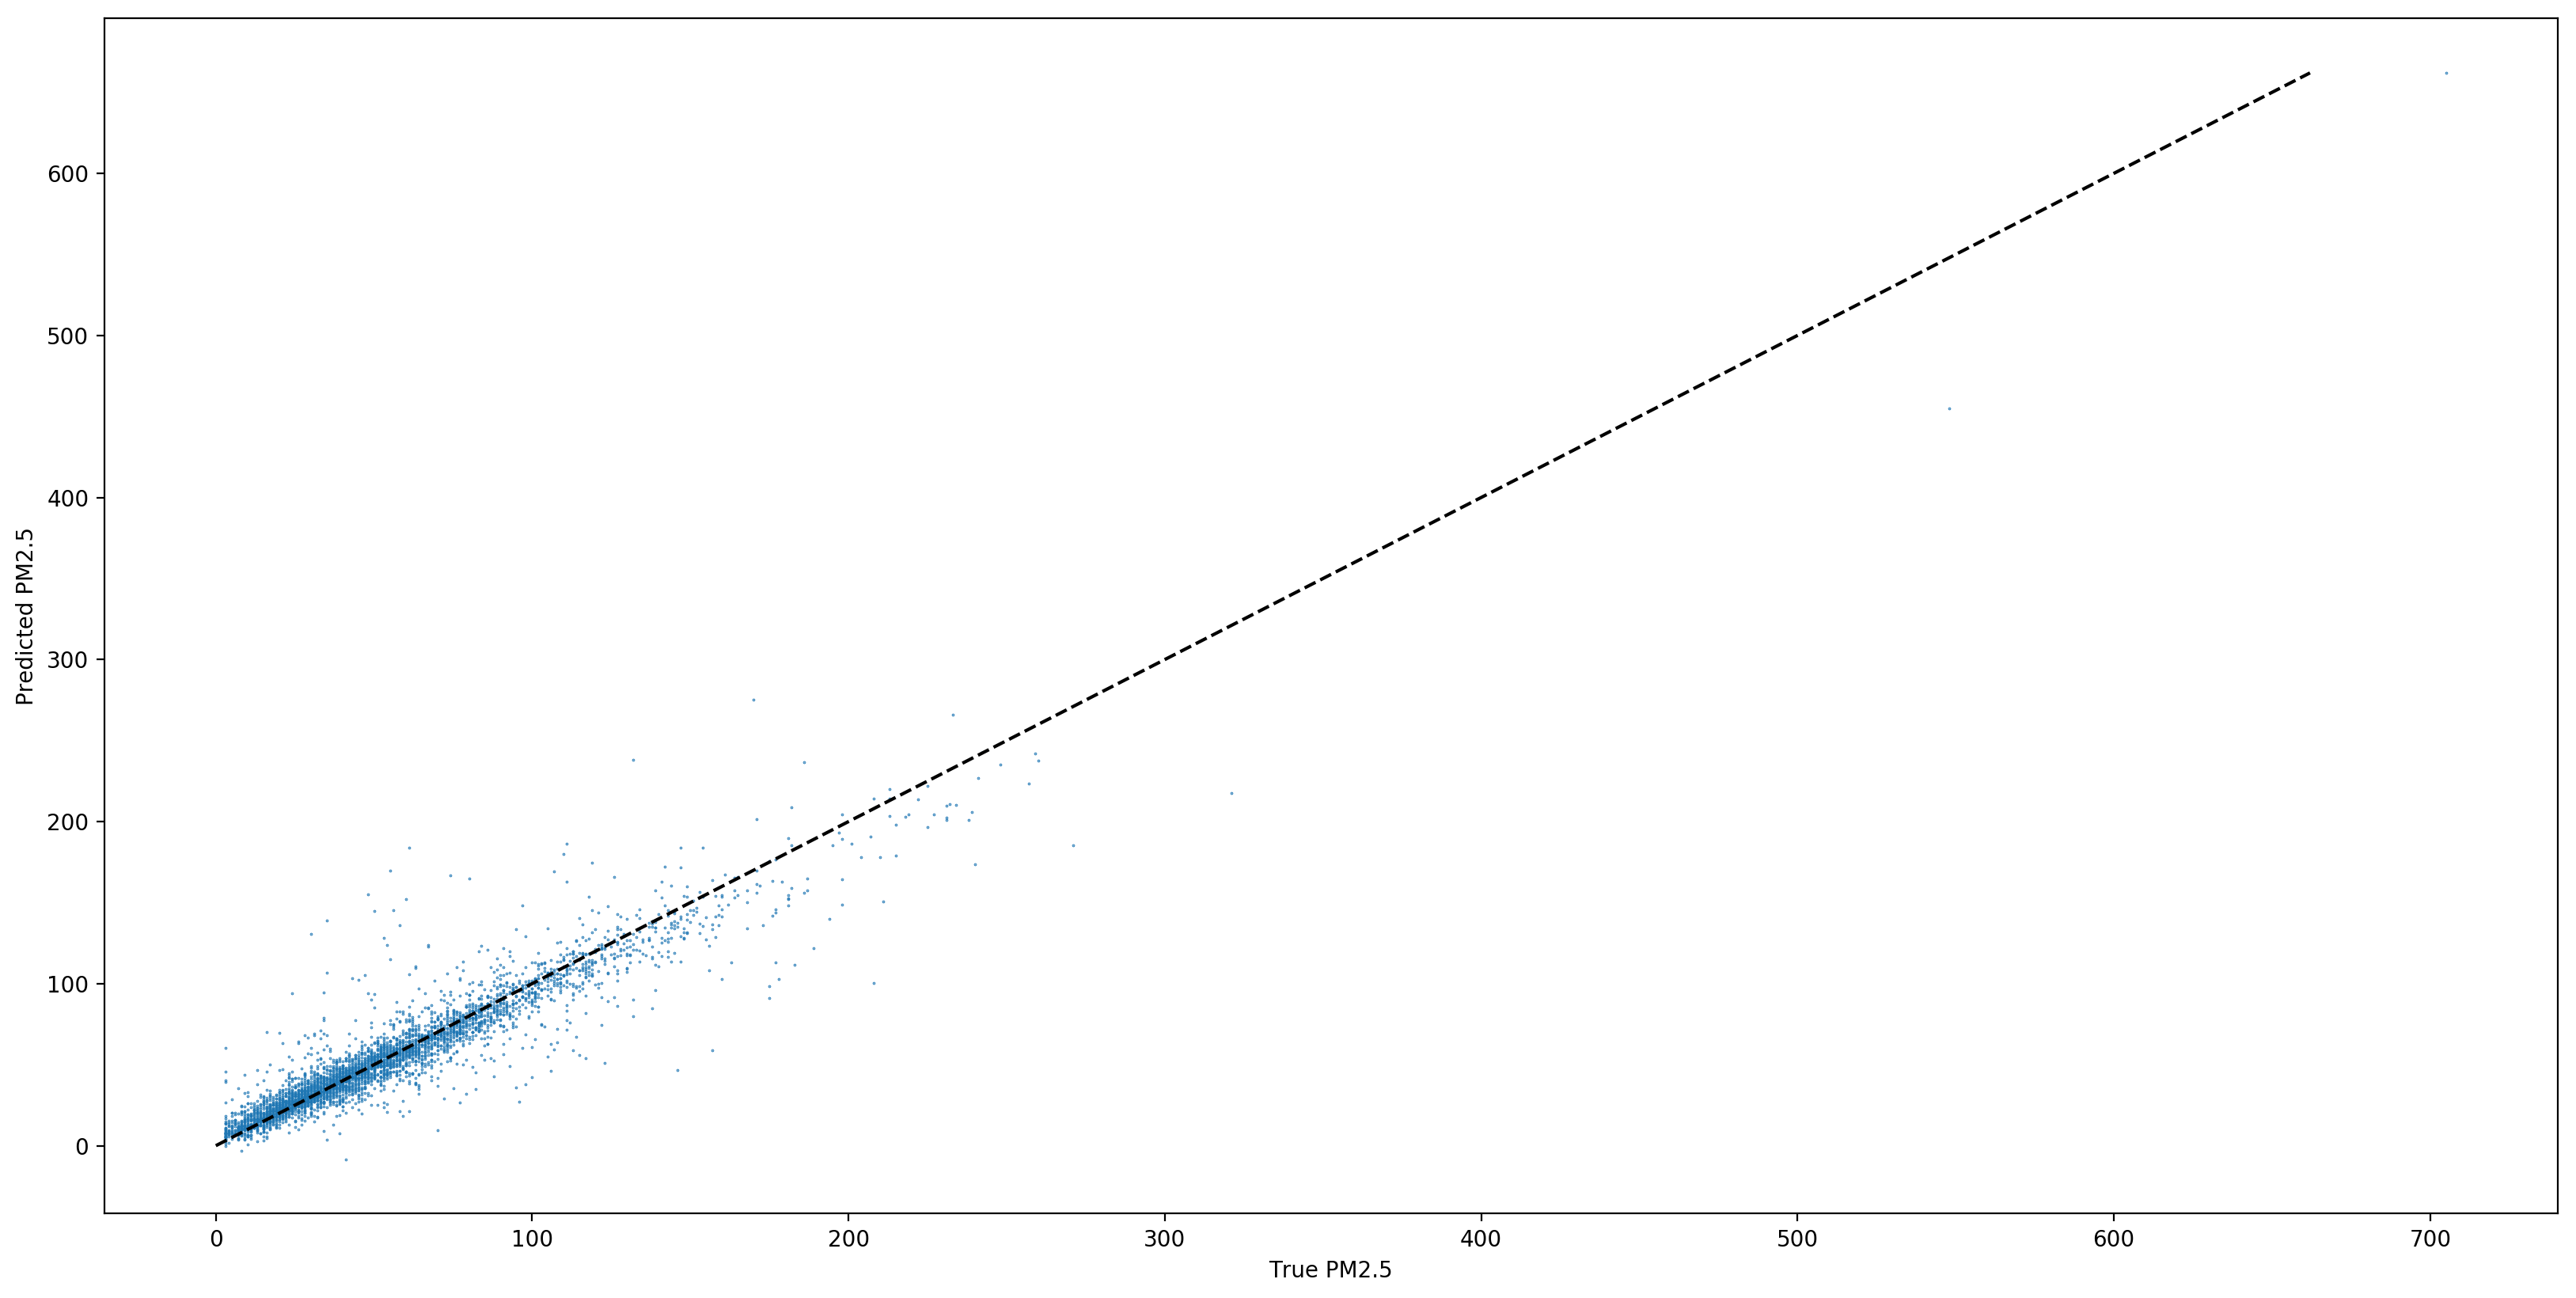

In [47]:
fig = plt.figure(figsize=(20,10), dpi=200)

plt.scatter(y_test[~y_test_na_idx], y_test_predicted[~y_test_na_idx], s=0.1) # "s" defines the size of the dots

# plot a line that shows the expected correlation between 
# the true pm2.5 value and the predicted pm2.5 value
max_val = min(y_test[~y_test_na_idx].max(), y_test_predicted[~y_test_na_idx].max())
plt.plot([0, max_val], [0, max_val], '--k') # '--': dashed,  'k': black
# for more line styles: see the official documentation: 
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html

plt.xlabel('True PM2.5')
plt.ylabel('Predicted PM2.5')
plt.show()
